In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from config.settings import settings
from scipy.stats import pearsonr

In [2]:
DATASETS_BASE = settings.MODULES_TO_DATASETS_PATH

## Transform Dataframe

On récupère le dataframe orginal, qu'on transforme afin d'avoir les polluants en features du df. Ce format correspond à l'input de notre modèle de machine learning.

In [3]:
df1_4 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_4, low_memory=False)

In [4]:
df1_4.columns

Index(['countryName', 'EPRTRSectorCode', 'eprtrSectorName',
       'EPRTRAnnexIMainActivityCode', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName',
       'facilityNameConfidentialityReason', 'Longitude', 'Latitude',
       'addressConfidentialityReason', 'City', 'targetRelease', 'pollutant',
       'emissions', 'reportingYear', 'releasesConfidentialityReason'],
      dtype='object')

In [5]:
def pollutant_features(d_frame: pd.DataFrame) -> pd.DataFrame:
    df_pivoted = d_frame\
    .pivot_table(
        index=['FacilityInspireID', 'reportingYear'],
        columns='pollutant',
        values='emissions',
        aggfunc='sum')\
    .reset_index()

    df_pivoted.iloc[:, 2:] = df_pivoted.iloc[:, 2:].fillna(0)

    return df_pivoted

In [6]:
def df_with_pollutant_features(df_unique: pd.DataFrame, df_pollutant: pd.DataFrame) -> pd.DataFrame:
    df_final = pd.merge(df_unique, df_pollutant, on=['FacilityInspireID', 'reportingYear'], how='left')
    # df_final = df_final.drop(columns=['index'])

    return df_final

In [7]:
def display_corr(df_pollutant: pd.DataFrame):
    correlation_matrix = df_pollutant.iloc[:, 15:].corr(method='pearson')

    plt.figure(figsize=(16, 12))

    heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)

    plt.title('Heatmap of Feature Correlations')

    plt.show()
    
    threshold = 0.75  # This is an arbitrary threshold

    high_correlations = np.where(np.abs(correlation_matrix) > threshold)

    high_correlations = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                        for x, y in zip(*high_correlations)
                        if x != y and x < y]
    
    for pair in high_correlations:
        corr_value, p_value = pearsonr(df_pollutant[pair[0]], df_pollutant[pair[1]])
        print(f"Correlation between {pair[0]} and {pair[1]}: {corr_value}, P-value: {p_value}")

    return heatmap

In [8]:
def drop_columns(d_frame: pd.DataFrame) -> pd.DataFrame:
    return d_frame.drop(columns=["countryName", "EPRTRSectorCode", 
                                 "EPRTRAnnexIMainActivityCode", "facilityNameConfidentialityReason",
                                 "Longitude", "Latitude", "addressConfidentialityReason", "City",
                                 "targetRelease", "releasesConfidentialityReason"])

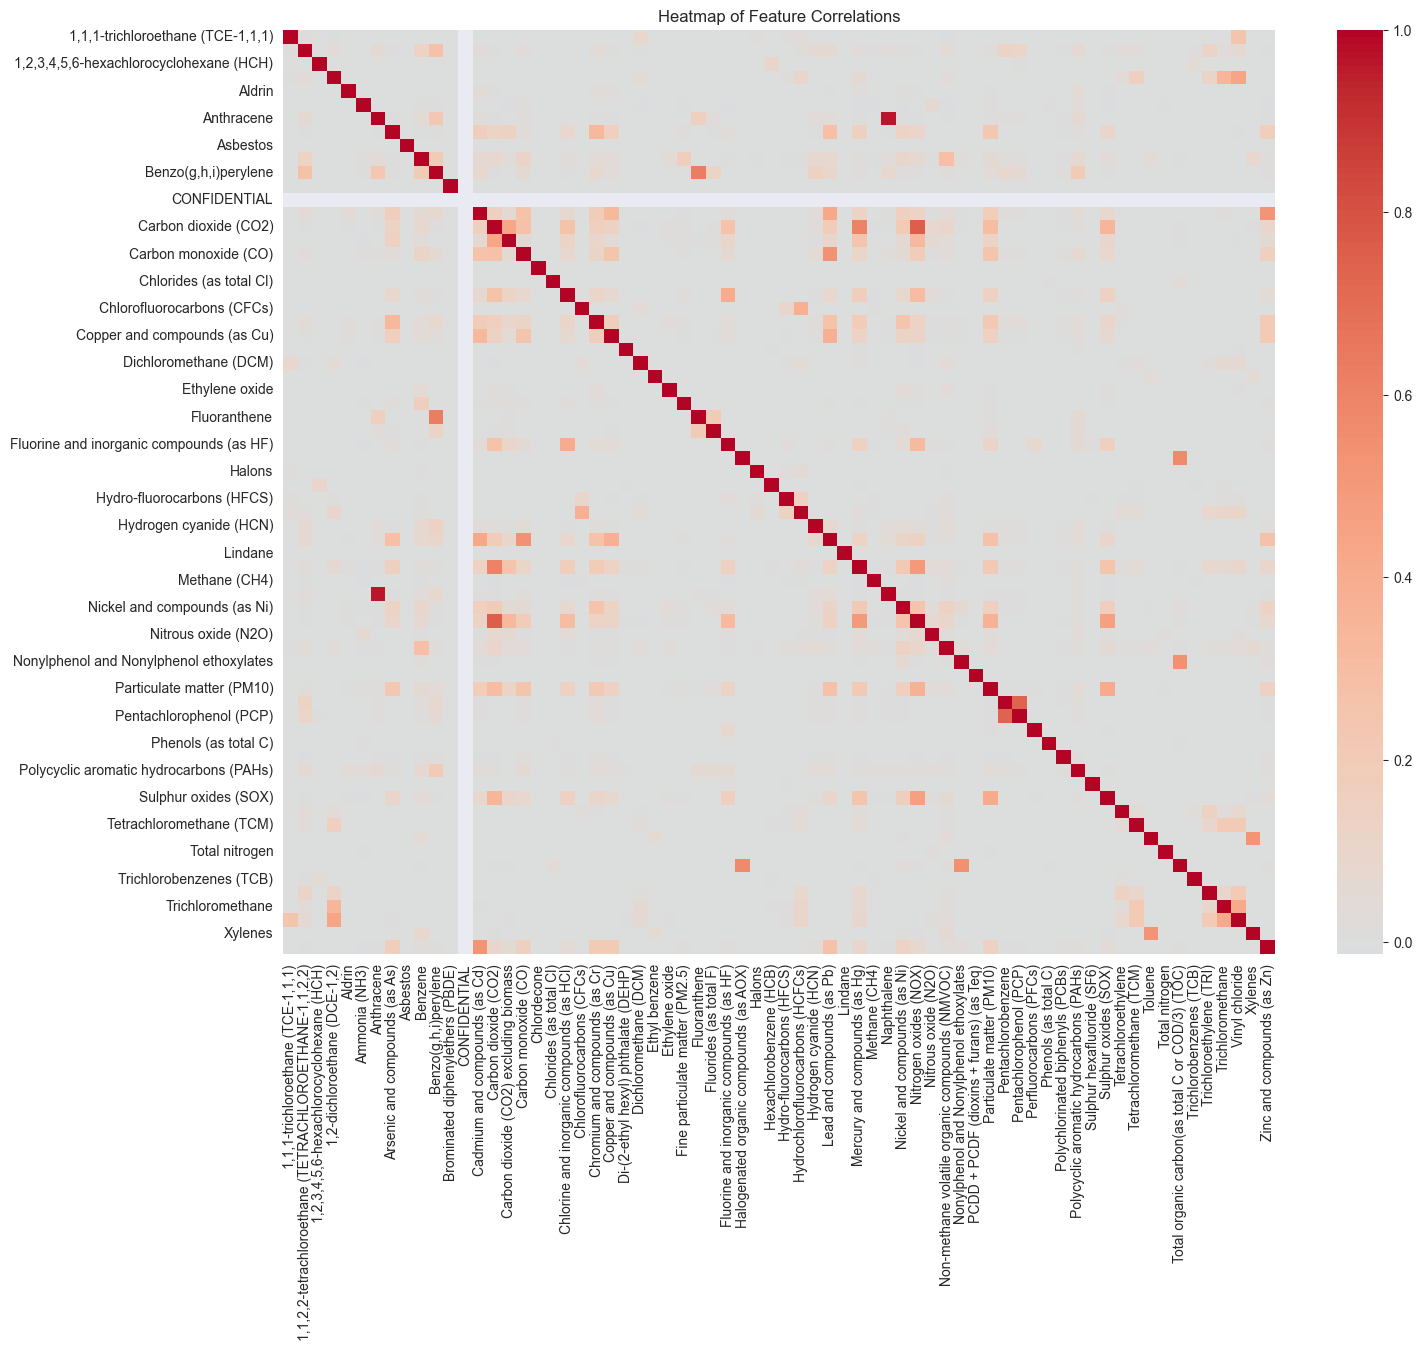

Correlation between Anthracene and Naphthalene: 0.9613208385860071, P-value: 0.0
Correlation between Carbon dioxide (CO2) and Nitrogen oxides (NOX): 0.7564119404282662, P-value: 0.0


<AxesSubplot: title={'center': 'Heatmap of Feature Correlations'}>

In [9]:
df_unique = df1_4.drop_duplicates(subset=['FacilityInspireID', 'reportingYear']).drop(columns=['pollutant', 'emissions'])
df_pollutant = pollutant_features(df1_4)
df_final = df_with_pollutant_features(df_unique, df_pollutant)
display_corr(df_final)

In [10]:
len(df_final[df_final["releasesConfidentialityReason"].isna()])

179090

In [11]:
df_final = df_final[df_final["releasesConfidentialityReason"].isna()]
df_final = drop_columns(df_final)
df_final = df_final[~df_final["eprtrSectorName"].isna()]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178251 entries, 0 to 179488
Data columns (total 73 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   eprtrSectorName                                        178251 non-null  object 
 1   EPRTRAnnexIMainActivityLabel                           178251 non-null  object 
 2   FacilityInspireID                                      178251 non-null  object 
 3   facilityName                                           178235 non-null  object 
 4   reportingYear                                          178251 non-null  int64  
 5   1,1,1-trichloroethane (TCE-1,1,1)                      178251 non-null  float64
 6   1,1,2,2-tetrachloroethane (TETRACHLOROETHANE-1,1,2,2)  178251 non-null  float64
 7   1,2,3,4,5,6-hexachlorocyclohexane (HCH)                178251 non-null  float64
 8   1,2-dichloroethane (DCE-1,2)           

## Clustering

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from joblib import dump

In [13]:
X = df_final.copy().drop(columns=["FacilityInspireID", "facilityName", 
                                  "reportingYear", "EPRTRAnnexIMainActivityLabel"])

### Kmeans

In [14]:
def cluster_by_sector_auto_kmeans(df, sector_col, pollutant_cols):
    clusters_info = {}
    # param_grid = {
    #     'n_clusters': range(2, 10),  # nombre de clusters
    #     'init': ['k-means++', 'random'],  # méthode d'initialisation
    #     'n_init': [10, 15],  # nombre de redémarrages
    #     'max_iter': [300, 400],  # nombre d'itérations maximum
    #     'tol': [1e-4, 1e-3],  # tolérance pour la convergence
    # }

    param_grid = {
        'n_clusters': [2],  # nombre de clusters
        'init': ['k-means++'],  # méthode d'initialisation
        'n_init': [10],  # nombre de redémarrages
        'max_iter': [100],  # nombre d'itérations maximum
        'tol': [1e-4],  # tolérance pour la convergence
    }

    for sector in df[sector_col].unique():
        sector_data = df[df[sector_col] == sector]
        pollutant_data = sector_data[pollutant_cols]

        scaler = MinMaxScaler()
        scaled_pollutant_data = scaler.fit_transform(pollutant_data)

        # Application de PCA
        # pca = PCA().fit(scaled_pollutant_data)  # Le nombre de composantes peut être déterminé en examinant la variance expliquée
        # pca_data = pca.transform(scaled_pollutant_data)

        # Initialisation des listes pour l'inertie et le score de silhouette
        inertia = []
        silhouette_scores = []
        results_list = []

        # Tester de 2 à 10 clusters
        for params in ParameterGrid(param_grid):
            kmeans = KMeans(**params, random_state=42)
            kmeans.fit(scaled_pollutant_data)
            
            # Calculez l'inertie et le score de silhouette
            inertia = kmeans.inertia_
            silhouette = silhouette_score(scaled_pollutant_data, kmeans.labels_)
            silhouette_scores.append(silhouette)
            
            # Ajoutez les résultats dans le dataframe
            results_list.append({
                'n_clusters': params['n_clusters'],
                'init': params['init'],
                'n_init': params['n_init'],
                'max_iter': params['max_iter'],
                'tol': params['tol'],
                'inertia': inertia,
                'silhouette': silhouette
            })

        results_df = pd.DataFrame(results_list, columns=['n_clusters', 'init', 'n_init', 'max_iter', 'tol', 'inertia', 'silhouette'])

        # Récupère le nombre de clusters avec le score de silhouette le plus élevé
        best_params_row  = results_df.loc[results_df['silhouette'].idxmax()]
        best_kmeans_params = best_params_row[['n_clusters', 'init', 'n_init', 'max_iter', 'tol']].to_dict()
        best_kmeans_params['n_clusters'] = int(best_kmeans_params['n_clusters'])
        best_kmeans_params['n_init'] = int(best_kmeans_params['n_init'])
        best_kmeans_params['max_iter'] = int(best_kmeans_params['max_iter'])
        best_kmeans_params['tol'] = float(best_kmeans_params['tol'])

        # Appliquer KMeans avec le nombre optimal de clusters
        final_kmeans = KMeans(**best_kmeans_params, random_state=42)
        final_kmeans.fit(scaled_pollutant_data)
        # clusters = final_kmeans.predict(scaled_pollutant_data)

        # Ajouter les labels de clusters au DataFrame original
        df.loc[df[sector_col] == sector, 'cluster'] = final_kmeans.labels_ 

        # Stocker les informations de scaling et de clustering pour le secteur
        clusters_info[sector] = {
            'scaler': scaler,
            'kmeans': final_kmeans,
            'inertia': inertia,
            'silhouette_scores': silhouette_scores
        }

        model_filename = f'kmeans_{sector}.joblib'
        dump(final_kmeans, model_filename)

    df['cluster'] = df['cluster'].astype(str)
    df['sectorCluster'] = df['eprtrSectorName'] + '_' + df['cluster']

    return df, clusters_info

In [15]:
# clustered_df_auto, clusters_info_auto = cluster_by_sector_auto_kmeans(X, X.columns[0], X.columns[1:])

0 étant l'optimal, plus la valeur est faible mieux le modèle est précis. Ici l'inertie est trop élevé alors le modèle n'est pas adapté à la donnée. Pour améliorer la précision, on peut changer le nombre de clusters mais aussi réduire le nombre de dimensions avec le PCA notamment.

('Chemical industry', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=9, random_state=42), 'inertia': [327.3753822574792, 308.23279221596806, 291.97372859749305, 278.6047935148726, 266.0394768770854, 257.9446690234355, 246.7374239932198, 235.6713567242673, 227.32904080299187], 'silhouette_scores': [0.7381165813736691, 0.7316877469414053, 0.738563592733481, 0.7430983118865891, 0.7450839097367639, 0.7390369655978896, 0.7317192951892604, 0.7558569593155618, 0.6432265137427086]})
('Chemical industry', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=9, random_state=42), 'inertia': [327.37538225747915, 308.23279221596795, 291.97372859749294, 278.60479351487254, 266.0394768770853, 257.9446690234355, 246.73742399321975, 235.67135672426724, 227.3290408029918], 'silhouette_scores': [0.738116581373628, 0.7316877469413609, 0.7385635927334371, 0.743098311886094, 0.7450839097362512, 0.739036965597379, 0.7317192951887412, 0.7558569593150491, 0.6432265137421586]})

('Other activities', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=4, random_state=42), 'inertia': [144.7029167704001, 131.96961194063437, 122.97088914296087, 116.58273946327986, 111.78743791191717, 106.71931989421013, 102.14646050678019, 97.08331729750338, 92.61223746302146], 'silhouette_scores': [0.6068273661801451, 0.6240357668557762, 0.6390550179519537, 0.3476920468738016, 0.35334918082305794, 0.3745721265742601, 0.3626147415621321, 0.37735451235082895, 0.38929967147993316]})
('Other activities', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=4, random_state=42), 'inertia': [144.70291677040012, 131.9696119406344, 122.97088914296087, 116.58273946327985, 111.78743791191715, 106.71931989421014, 102.1464605067802, 97.08331729750338, 92.61223746302144], 'silhouette_scores': [0.6068273661771905, 0.624035766852785, 0.6390550179489072, 0.3476920468640612, 0.35334918081331046, 0.3745721265646756, 0.36261474155226286, 0.3773545123408797, 0.38929967146996136]})

('Paper and wood production and processing', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=2, random_state=42), 'inertia': [343.7758763818783, 288.7303961447995, 259.8866435993575, 240.47535959815653, 226.02392715951044, 212.38854981558157, 200.86104234873832, 194.18575730258652, 184.49569395573505], 'silhouette_scores': [0.5910912561874951, 0.5248446402669223, 0.5292874154666453, 0.5379055297241107, 0.5428355253483718, 0.48148618900785417, 0.4363769719742007, 0.4433133224543377, 0.44416256912085017]})
('Paper and wood production and processing', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=2, random_state=42), 'inertia': [343.7758763818782, 288.7303961447995, 259.88664359935746, 240.47535959815656, 226.02392715951038, 212.38854981558148, 200.86104234873832, 194.18575730258655, 184.49569395573508], 'silhouette_scores': [0.5910912561873687, 0.5248446402666923, 0.5292874154664099, 0.537905529723877, 0.5428355253481337, 0.4814861890075362, 0.4363769719738097, 0.44331332245395266, 0.4441625691204262]})

('Mineral industry', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=2, random_state=42), 'inertia': [336.40547256849607, 301.9783916004322, 270.9029038537452, 251.78392099216978, 237.04601171722385, 222.37028027299485, 214.18071875517768, 205.75565179481677, 200.42537838955346], 'silhouette_scores': [0.6605701187438752, 0.6226095080298607, 0.6380972406537079, 0.6325327141025242, 0.6266278061115846, 0.6349714955069337, 0.6315896076661146, 0.5098984257894317, 0.5374048575443653]})
('Mineral industry', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=2, random_state=42), 'inertia': [336.4054725684959, 301.97839160043213, 270.90290385374516, 251.78392099216975, 237.04601171722382, 222.3702802729948, 214.18071875517762, 205.75565179481674, 200.4253783895534], 'silhouette_scores': [0.6605701187437503, 0.6226095080296628, 0.6380972406533238, 0.6325327141021201, 0.6266278061111281, 0.6349714955064537, 0.6315896076656456, 0.5098984257888224, 0.5374048575437126]})

('Animal and vegetable products from the food and beverage sector', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=3, random_state=42), 'inertia': [157.82130617189776, 136.35939080530386, 124.64334706919831, 114.59725811172034, 107.15381250051644, 100.52842007938744, 94.23505570045832, 88.47218133130505, 83.64851442949896], 'silhouette_scores': [0.6681294859606015, 0.6881818020750757, 0.6291954178253337, 0.6278430761148975, 0.6204803481831833, 0.6306740988496898, 0.49046664974015247, 0.632232549562339, 0.6330959267042572]})
('Animal and vegetable products from the food and beverage sector', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=3, random_state=42), 'inertia': [157.82130617189773, 136.35939080530383, 124.6433470691983, 114.59725811172035, 107.15381250051641, 100.52842007938746, 94.23505570045833, 88.47218133130505, 83.64851442949895], 'silhouette_scores': [0.6681294859601299, 0.6881818020745952, 0.6291954178247139, 0.6278430761140497, 0.6204803481820684, 0.6306740988487648, 0.4904666497386971, 0.6322325495610353, 0.6330959267029701]})

('Waste and wastewater management', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=3, random_state=42), 'inertia': [193.58516822098724, 180.38909333356116, 170.2596556908804, 162.02944755052934, 156.65248992379924, 148.38094488302528, 143.09457924169848, 138.01274619594713, 132.11514408053404], 'silhouette_scores': [0.7160155691284532, 0.7242729836392768, 0.5641645074699257, 0.5714572576765603, 0.5817194097942793, 0.579560568963852, 0.58437677699677, 0.5883747717697149, 0.5914373126131987]})
('Waste and wastewater management', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=3, random_state=42), 'inertia': [193.58516822098727, 180.3890933335612, 170.25965569088044, 162.02944755052937, 156.65248992379927, 148.38094488302528, 143.09457924169854, 138.01274619594713, 132.11514408053407], 'silhouette_scores': [0.7160155691277728, 0.7242729836385913, 0.5641645074683082, 0.5714572576749474, 0.5817194097926504, 0.5795605689622092, 0.5843767769951443, 0.5883747717680834, 0.591437312611563]})

('Production and processing of metals', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=2, random_state=42), 'inertia': [306.628990061308, 284.38155988179324, 263.3575964319005, 248.36869036641727, 235.56271243036804, 224.82236787724892, 221.90909116905226, 204.0570922905157, 197.84789917670318], 'silhouette_scores': [0.8576591745758252, 0.7816934094761205, 0.7857541592207048, 0.7914920257695914, 0.7958075329967765, 0.7977713766672159, 0.7939567401254876, 0.7966328446463969, 0.7735311391744556]})
('Production and processing of metals', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=2, random_state=42), 'inertia': [306.6289900613081, 284.38155988179324, 263.3575964319005, 248.36869036641724, 235.562712430368, 224.82236787724887, 221.9090911690523, 204.0570922905157, 197.8478991767032], 'silhouette_scores': [0.8576591745757703, 0.7816934094760415, 0.7857541592203481, 0.7914920257688557, 0.7958075329960401, 0.7977713766664796, 0.7939567401247456, 0.7966328446456471, 0.7735311391736762]})

('Energy sector', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=2, random_state=42), 'inertia': [370.42962233723415, 339.96083671364835, 309.94640828910497, 288.77491119383103, 275.8285053526658, 266.9195165060497, 258.0502900479743, 249.57443096306724, 237.04242954219035], 'silhouette_scores': [0.850043192994506, 0.8383330509625705, 0.7882166217406487, 0.777556690734807, 0.7781769646590974, 0.778922210084711, 0.6753118409602061, 0.7248663068879662, 0.6550801515632112]})
('Energy sector', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=2, random_state=42), 'inertia': [370.42962233723415, 339.96083671364823, 309.94640828910485, 288.774911193831, 275.8285053526657, 266.91951650604966, 258.0502900479742, 249.57443096306716, 237.0424295421903], 'silhouette_scores': [0.8500431929944828, 0.838333050962545, 0.7882166217406165, 0.7775566907347726, 0.7781769646590652, 0.7789222100846785, 0.6753118409601357, 0.7248663068879111, 0.6550801515631303]})

('Intensive livestock production and aquaculture', {'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=9, random_state=42), 'inertia': [28.61090636056805, 24.693349239234, 21.555056803215123, 19.654668020704474, 17.47457418626366, 15.661599175572006, 13.573911387879605, 12.013430544326951, 10.421379415027843], 'silhouette_scores': [0.9960157998234939, 0.9961067905258097, 0.9962304335438744, 0.9962882210295705, 0.9963468344978577, 0.9964024865047629, 0.9964544934766274, 0.99650405525205, 0.9956276184715013]})
('Intensive livestock production and aquaculture', {'PCA': PCA(), 'scaler': MinMaxScaler(), 'kmeans': KMeans(n_clusters=9, random_state=42), 'inertia': [28.610906360568062, 24.69334923923401, 21.555056803215134, 19.654668020704477, 17.47457418626366, 15.661599175572013, 13.573911387879614, 12.013430544326962, 10.421379415027852], 'silhouette_scores': [0.9960157998234667, 0.9961067905257828, 0.9962304335438474, 0.9962882210295433, 0.9963468344978307, 0.9964024865047357, 0.9964544934766003, 0.9965040552520229, 0.9956276184714618]})

En comparrant silhouette_scores entre les modèles Kmeans entrainé sur du PCA et ceux sans, on peut voir que la différence est extrêmement minime.

Les secteurs d'activités sont déjà segmentés, par conséquent effectué le PCA dessus n'a pas d'impact, à l'inverse, si on effectue le PCA sur le dataset global alors la différence est notable.

### DBSCAN

In [16]:
# def cluster_by_sector_auto(df, sector_col, pollutant_cols):
#     clusters_info = {}
    
#     # Plage de paramètres pour DBSCAN
#     param_grid = {
#         'eps': [0.1, 0.2, 0.3, 0.5, 0.6, 0.7],  # Valeurs d'epsilon à tester
#         'min_samples': [5, 10, 15, 20],  # Valeurs de min_samples à tester
#     }

#     for sector in df[sector_col].unique():
#         sector_data = df[df[sector_col] == sector]
#         pollutant_data = sector_data[pollutant_cols]

#         scaler = MinMaxScaler()
#         scaled_pollutant_data = scaler.fit_transform(pollutant_data)

#         results_list = []

#         # Teste différentes combinaisons de eps et min_samples
#         for params in ParameterGrid(param_grid):
#             dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
#             cluster_labels = dbscan.fit_predict(scaled_pollutant_data)
            
#             # Calculez le score de silhouette, ignorer si pas de clusters trouvés ou un seul cluster
#             if len(set(cluster_labels)) > 1:
#                 silhouette = silhouette_score(scaled_pollutant_data, cluster_labels)
#                 results_list.append({
#                     'eps': params['eps'],
#                     'min_samples': params['min_samples'],
#                     'silhouette': silhouette
#                 })

#         # Créez un DataFrame à partir des résultats
#         if results_list:  # Vérifiez si la liste n'est pas vide
#             results_df = pd.DataFrame(results_list)
            
#             # Récupérez les paramètres avec le score de silhouette le plus élevé
#             best_params_row = results_df.loc[results_df['silhouette'].idxmax()]
#             best_dbscan_params = {
#                 'eps': best_params_row['eps'],
#                 'min_samples': int(best_params_row['min_samples'])  # Convertir en entier
#             }
            
#             # Appliquer DBSCAN avec les meilleurs paramètres trouvés
#             final_dbscan = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
#             final_clusters = final_dbscan.fit_predict(scaled_pollutant_data)
            
#             # Ajouter les labels de clusters au DataFrame original
#             df.loc[df[sector_col] == sector, 'cluster'] = final_clusters
#             # Stocker les informations de clustering pour le secteur
#             clusters_info[sector] = {
#                 'scaler': scaler,
#                 'dbscan': final_dbscan,
#                 'silhouette': best_params_row['silhouette']
#             }
#         else:
#             print(f"No valid clusters found for sector {sector} with given DBSCAN parameters.")

#     # Créer une feature combinée pour le secteur et le cluster
#     df['cluster'] = df['cluster'].astype(str)
#     df['sectorCluster'] = df[sector_col] + '_' + df['cluster']

#     return df, clusters_info


In [17]:
# X.eprtrSectorName.value_counts()

In [18]:
# clustered_df_auto, clusters_info_auto = cluster_by_sector_auto(X, X.columns[0], X.columns[1:])

### OPTICS

In [19]:
def cluster_by_sector_auto_optics(df, sector_col, pollutant_cols):
    clusters_info = {}
    
    # param_grid = {
    #     'min_samples': [2, 5, 10], 
    #     'xi': [0.05, 0.1, 0.15],
    #     'min_cluster_size': [0.01, 0.05, 0.1]
    # }

    param_grid = {
        'min_samples': [2], 
        'xi': [0.05],
        'min_cluster_size': [0.01]
    }

    for sector in df[sector_col].unique():
        sector_data = df[df[sector_col] == sector]
        pollutant_data = sector_data[pollutant_cols]

        scaler = MinMaxScaler()
        scaled_pollutant_data = scaler.fit_transform(pollutant_data)

        best_silhouette = -1
        best_params = None
        best_model = None

        # Tester toutes les combinaisons de paramètres dans la grille
        for params in ParameterGrid(param_grid):
            optics_model = OPTICS(**params)
            optics_model.fit(scaled_pollutant_data)

            # Extraire les labels de clusters
            labels = optics_model.labels_

            # Calculer le score de silhouette seulement si plus d'un cluster est détecté (et pas de bruit seulement)
            if len(set(labels)) - (1 if -1 in labels else 0) > 1:  # Exclure le bruit du compte des clusters
                silhouette = silhouette_score(scaled_pollutant_data, labels)
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_params = params
                    best_model = optics_model

        # Vérifier si un modèle valide a été trouvé
        if best_model is not None:
            # Ajouter les labels de clusters au DataFrame original
            df.loc[df[sector_col] == sector, 'cluster'] = best_model.labels_

            # Enregistrement du meilleur modèle OPTICS pour le secteur actuel
            model_filename = f'optics_{sector}.joblib'
            dump(best_model, model_filename)

            # Stocker les informations de scaling et de clustering pour le secteur
            clusters_info[sector] = {
                'scaler': scaler,
                'optics': best_model,
                'silhouette': best_silhouette,
                'params': best_params
            }
        else:
            print(f"No suitable clusters found for sector {sector} with given OPTICS parameters.")
    
    # Conversion des étiquettes de cluster en type string et création de la feature combinée
    df['cluster'] = df['cluster'].astype(str)
    df['sectorCluster'] = df[sector_col] + '_' + df['cluster']

    return df, clusters_info

In [20]:
# clustered_df_auto, clusters_info_auto = cluster_by_sector_auto_optics(X, X.columns[0], X.columns[1:])

### Evaluate

In [21]:
def compare_models(df, sector_col, pollutant_cols):
    kmeans_info, optics_info = {}, {}

    # Utiliser les fonctions définies précédemment pour entraîner KMeans et OPTICS
    df, kmeans_info = cluster_by_sector_auto_kmeans(df, sector_col, pollutant_cols)
    df, optics_info = cluster_by_sector_auto_optics(df, sector_col, pollutant_cols)

    # Comparer les performances
    for sector in df[sector_col].unique():
        kmeans_silhouette = kmeans_info[sector]['silhouette_scores']
        optics_silhouette = optics_info[sector]['silhouette']

        print(f"Sector: {sector}")
        print(f"KMeans Silhouette Score: {kmeans_silhouette}")
        print(f"OPTICS Silhouette Score: {optics_silhouette}")

        if kmeans_silhouette > optics_silhouette:
            print("KMeans performs better for this sector.")
        elif kmeans_silhouette < optics_silhouette:
            print("OPTICS performs better for this sector.")
        else:
            print("Both models perform equally.")

In [22]:
compare_models(X, X.columns[0], X.columns[1:])

C:\Users\Sysiph'Eros\Desktop\Environmental_Impact\venv\Lib\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Sysiph'Eros\Desktop\Environmental_Impact\venv\Lib\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Sysiph'Eros\Desktop\Environmental_Impact\venv\Lib\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Sysiph'Eros\Desktop\Environmental_Impact\venv\Lib\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Sysiph'Eros\Desktop\Environmental_Impact\venv\Lib\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero enco

Sector: Chemical industry
KMeans Silhouette Score: [0.7381165813736691]
OPTICS Silhouette Score: -0.31793309187175994
KMeans performs better for this sector.
Sector: Other activities
KMeans Silhouette Score: [0.6068273661801451]
OPTICS Silhouette Score: -0.26687351291657374
KMeans performs better for this sector.
Sector: Paper and wood production and processing
KMeans Silhouette Score: [0.5910912561874951]
OPTICS Silhouette Score: -0.28322610877021825
KMeans performs better for this sector.
Sector: Mineral industry
KMeans Silhouette Score: [0.6605701187438752]
OPTICS Silhouette Score: -0.2266915623593407
KMeans performs better for this sector.
Sector: Animal and vegetable products from the food and beverage sector
KMeans Silhouette Score: [0.6681294859606015]
OPTICS Silhouette Score: -0.19123699152294177
KMeans performs better for this sector.
Sector: Waste and wastewater management
KMeans Silhouette Score: [0.7160155691284532]
OPTICS Silhouette Score: -0.48821783775234584
KMeans perfo